In [39]:
import pandas as pd
import numpy as np
import ast
import seaborn

# Evaluation
## 1. experiment reuslts proccseing

In [36]:
df_results=pd.read_csv('results/summary_results.csv')
df_results["validation_perplexities"]=df_results["validation_perplexities"].apply(ast.literal_eval)
df_results["train_perplexities"]=df_results["train_perplexities"].apply(ast.literal_eval)

df_results["min_perplexity_val"]=df_results["validation_perplexities"].apply(min)
df_results["min_perplexity_train"]=df_results["train_perplexities"].apply(min)
df_results['min loss epoch'] = df_results['validation_perplexities'].apply(lambda x: x.index(min(x)))


In [38]:
df_results.sort_values(by='min_perplexity_val',inplace=True)
df_results.to_csv("results/df_results_processed.csv")

C:\Users\galbe\AppData\Local\Temp\ipykernel_40616\2853391642.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  seaborn.heatmap(df_results.drop(columns=["hidden_dim",'lstm_layer','epochs']).corr())


<Axes: >

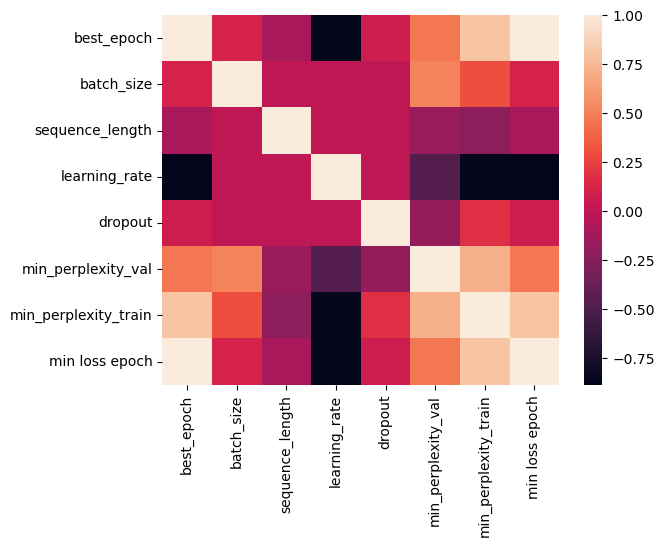

In [43]:
seaborn.heatmap(df_results.drop(columns=["hidden_dim",'lstm_layer','epochs']).corr())

## 2. Choose the best model
1. {epoch : 15, hidden dimensions : 40, lstm layer : 2, batch size: 16, sequence lenght: 5, learning rate : 0.0001,dropout:0.1, model:  merge, midi embedding: graph} <br>
2. {epoch : 7, hidden dimensions : 40, lstm layer : 2, batch size: 16, sequence lenght: 5, learning rate : 0.001
,dropout:0.1, model:  naive, midi embedding: modified}